### ControlNet Demo

This demo is based on huggingface controlnet [demo](https://huggingface.co/blog/controlnet)

In [7]:
!pip install diffusers transformers xformers git+https://github.com/huggingface/accelerate.git --u[grade]
!pip install opencv-contrib-python controlnet_aux --upgrade
!pip install triton --upgrade


Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: --u[grade]
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 MB 40.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.9/261.9 kB 79.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 94.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.8/220.8 kB 81.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.2/313.2 kB 91.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 92.2 MB/s eta 0:00:00:00:0100:01
  Using cached safetensors-0.3.1-cp310-cp310-manylinux_2_17_x86_

### Check the versions of the libraries

```python

In [11]:
import sys
import torch, diffusers
print(sys.version)
print(torch.__version__)
print(diffusers.__version__)

3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:20:04) [GCC 11.3.0]
2.0.1+cu117
0.18.1


**Note** 

If you encoutered an error like:

`symbol cublasLtGetStatusString version libcublasLt.so.11 not defined in file libcublasLt.so.11 with link time reference`

set the library path before running jupyter notebook.

`
export LD_LIBRARY_PATH=/home/rowel/anaconda3/envs/diffusion/lib/python3.10/site-packages/nvidia/cublas/lib
`

Reason: Incompatibilities with built-in cuda library.

Note: Best to update to the latest `torch` and `diffusers` versions.

#### Load an image

We use the famous "Girl with a Pearl Earring" painting by Johannes Vermeer.

```python

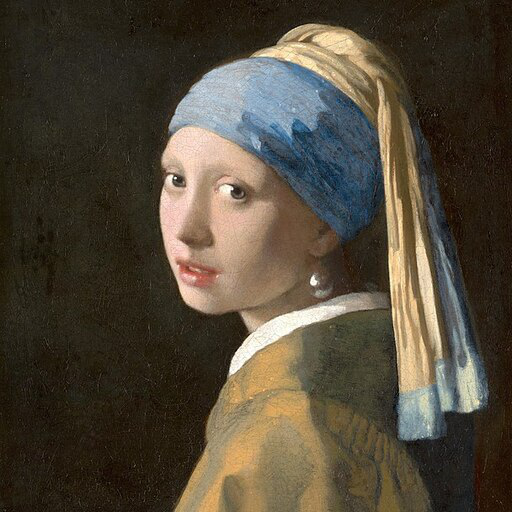

In [12]:
from diffusers.utils import load_image

#image = load_image(
#    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
#)
image = load_image("input_image_vermeer.png")
image

### Produce a conditional image sample

Produce an edge detected version of `image`.

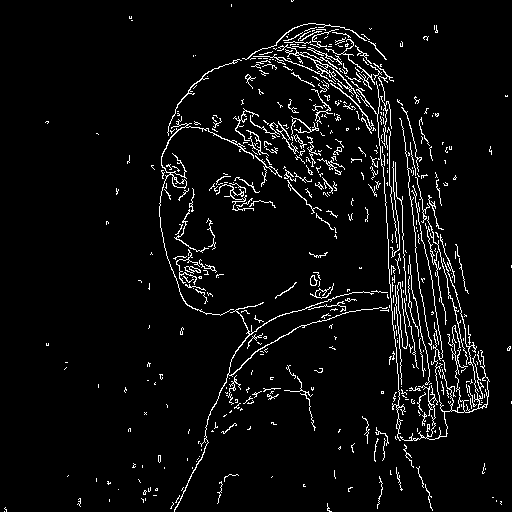

In [13]:
import cv2
from PIL import Image
import numpy as np

image = np.array(image)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)
canny_image


### Load ControlNet and Diffusion models

```python

In [6]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

### Load a Scheduler



In [14]:
from diffusers import UniPCMultistepScheduler

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)


### Enable CPU Offloading to Handle Multiple Model Inference and Fast FlashAttention



```python

In [15]:
pipe.enable_model_cpu_offload()
pipe.enable_xformers_memory_efficient_attention()


### Create Helper Functions

In [16]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid


### Create the Prompts

In [17]:
prompt = ", best quality, extremely detailed"
prompt = [t + prompt for t in ["Sandra Oh", "Kim Kardashian", "rihanna", "taylor swift"]]
generator = [torch.Generator(device="cpu").manual_seed(2) for i in range(len(prompt))]


### Run the Stable Diffusion with ControlNet 

  0%|          | 0/20 [00:00<?, ?it/s]

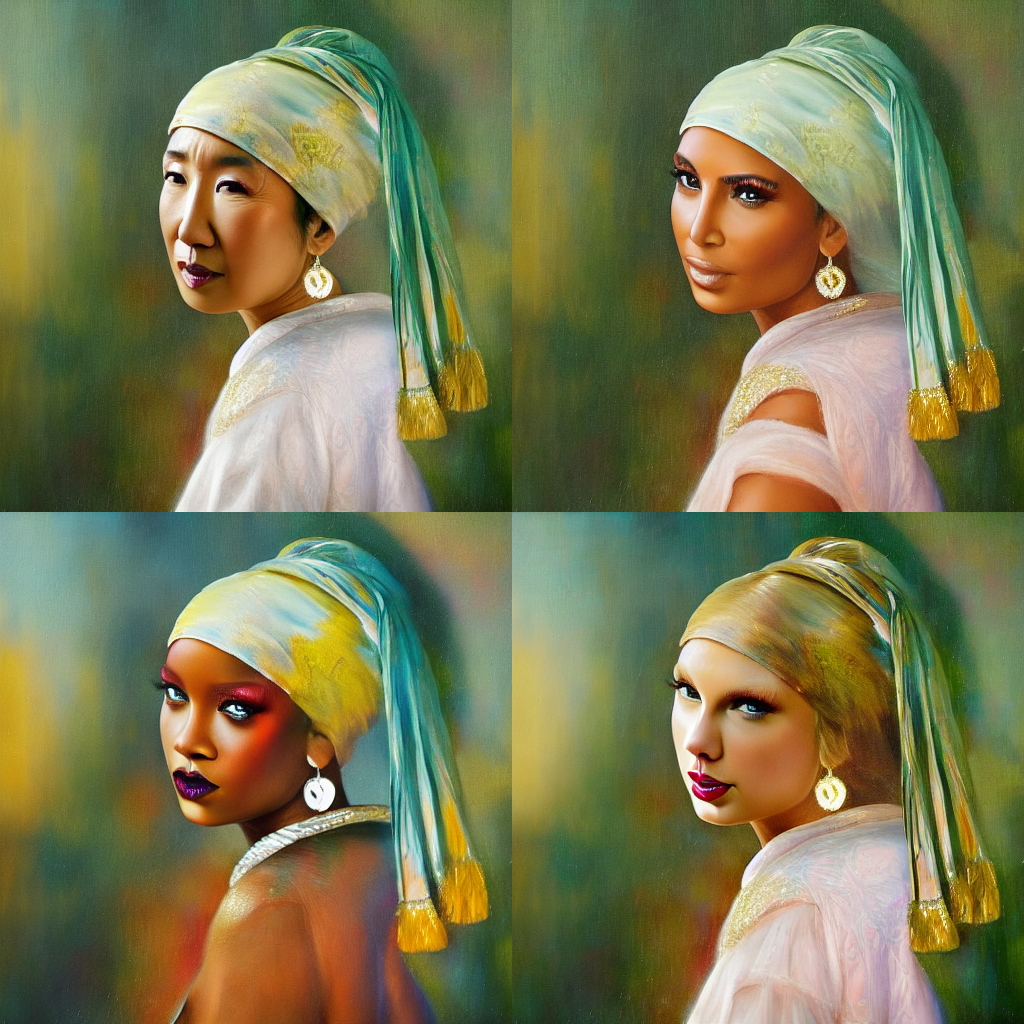

In [18]:
output = pipe(
    prompt,
    canny_image,
    negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality"] * 4,
    num_inference_steps=20,
    generator=generator,
)

image_grid(output.images, 2, 2)
